# 금융 데이터 전처리

## 데이터 불러오기
- 데이터 목록
    - 일별 자살자 수 통계 : [mdis](https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240) 사망원인통계
    - 우울증 관련 통계 : [보건의료빅데이터개방시스템](http://opendata.hira.or.kr/op/opc/olapMfrnIntrsIlnsInfo.do)
    - 소비자물가지수 : [KOSIS](https://kosis.kr/statHtml/statHtml.do?orgId=301&tblId=DT_005Y006&vw_cd=MT_ZTITLE&list_id=301_30106_4_2_2&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=MT_ZTITLE&path=%252FstatisticsList%252FstatisticsListIndex.do)
    - 가계부채 : [가계신용 동향](https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1076&param=003)
    - kospi 지수, 환율 : [FinanceDataReader](https://github.com/FinanceData/FinanceDataReader) 라이브러리
    - 기상데이터 : [기상청 기상자료개방포털](https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do)

## fdr 라이브러리

In [7]:
!pip install -U finance-datareader

In [8]:
import FinanceDataReader as fdr

fdr.__version__

'0.9.33'

In [9]:
from pandas_datareader import data
from datetime import datetime

start_date = datetime(2011,1,1)
end_date = datetime(2020,12,31)

df_ks11 = fdr.DataReader('KS11', start_date, end_date)
df_ks11

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2011-01-03,2070.08,2063.69,2070.09,2054.83,3.540800e+08,0.0093
2011-01-04,2085.14,2074.56,2085.14,2069.12,4.159100e+08,0.0073
2011-01-05,2082.55,2083.10,2087.14,2076.92,3.860600e+08,-0.0012
2011-01-06,2077.61,2094.35,2096.65,2066.10,4.078300e+08,-0.0024
2011-01-07,2086.20,2073.68,2086.20,2068.66,3.355600e+08,0.0041
...,...,...,...,...,...,...
2020-12-23,2759.82,2737.74,2769.08,2716.28,1.120000e+09,0.0096
2020-12-24,2806.86,2762.60,2812.16,2762.60,1.030000e+09,0.0170
2020-12-28,2808.60,2820.95,2834.59,2799.56,1.010000e+09,0.0006


### Close data만 남기고 삭제

In [10]:
df_ks11 = df_ks11.Close.reset_index().rename(columns={'Date':'date'})
df_ks11

,date,Close
0,2011-01-03,2070.08
1,2011-01-04,2085.14
2,2011-01-05,2082.55
3,2011-01-06,2077.61
4,2011-01-07,2086.20
...,...,...
2459,2020-12-23,2759.82
2460,2020-12-24,2806.86
2461,2020-12-28,2808.60
2462,2020-12-29,2820.51


## datareader 라이브러리

In [11]:
from pandas_datareader import data
from datetime import datetime

start_date = datetime(2011,1,1)
end_date = datetime(2020,12,31)

df_kospi = data.get_data_yahoo("^KS11", start_date, end_date) 
df_kospi = df_kospi.Close.reset_index().rename(columns={'Date':'date'})
df_kospi

,date,Close
0,2011-01-03,2070.080078
1,2011-01-04,2085.139893
2,2011-01-05,2082.550049
3,2011-01-06,2077.610107
4,2011-01-07,2086.199951
...,...,...
2455,2020-12-23,2759.820068
2456,2020-12-24,2806.860107
2457,2020-12-28,2808.600098
2458,2020-12-29,2820.510010


## 두 데이터셋 비교
- datareader로 불러온 자료와 fdr로 불러온 자료의 shape이 다름을 확인.
- 두 데이터프레임 비교한 결과 4일에 해당하는 자료가 datareader로 불러온 자료에 빠져 있었음.
- fdr로만 데이터 불러오기로.

In [12]:
print(df_ks11.shape),
print(df_kospi.shape)

(2464, 2)
(2460, 2)


In [13]:
def GetDifferences(df1, df2):
    df = pd.concat([df1, df2]).reset_index(drop=True)
    idx = [diff[0] for diff in df.groupby(list(df.columns)).groups.values() if len(diff) == 1]
    return df.reindex(idx)

In [17]:
import pandas as pd

GetDifferences(pd.DataFrame(df_ks11['date']), pd.DataFrame(df_kospi['date'])) ## 해당 날짜에는 데이터가 있었음.

,date
185,2011-10-04
743,2013-12-31
1663,2017-09-22
1720,2017-12-20


## kospi 데이터 날짜와 align

### date dataframe 만들기

In [18]:
import datetime

index = pd.date_range(start = '2011-01-01', end = '2020-12-31', freq= 'D')

columns = ['weekday']

df_date = pd.DataFrame(index = index, columns = columns)
df_date = df_date.fillna(0)
df_date.index.name = 'date'
df_date.reset_index(inplace = True)
df_date.date = df_date.date.astype(str)

df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     3653 non-null   object
 1   weekday  3653 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB


In [19]:
df_ks11.date = df_ks11.date.astype('str')

df_kospi = pd.merge(df_date, df_ks11, how = 'left', on = 'date')
df_kospi = df_kospi.ffill()

In [20]:
df_kospi.isnull().sum() ## 결측치 : 2011년 신년 휴장일 2일

date       0
weekday    0
Close      2
dtype: int64

In [21]:
## 2010년 마지막 kospi지수로 대체

df_kospi.iloc[0,2] = 2051 ##2010년 12월30일 kospi 지수
df_kospi.iloc[1,2] = 2051

In [22]:
df_kospi

,date,weekday,Close
0,2011-01-01,0,2051.00
1,2011-01-02,0,2051.00
2,2011-01-03,0,2070.08
3,2011-01-04,0,2085.14
4,2011-01-05,0,2082.55
...,...,...,...
3648,2020-12-27,0,2806.86
3649,2020-12-28,0,2808.60
3650,2020-12-29,0,2820.51
3651,2020-12-30,0,2873.47


<AxesSubplot:>

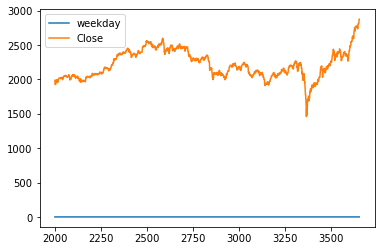

In [23]:
df_kospi[2000:].plot( kind = 'line' )

# 환율 데이터

In [24]:
df_rate = fdr.DataReader('USD/KRW', '2011-01-01','2020-12-31')

df_rate = df_rate['Close'].reset_index()
df_rate.rename(columns = {'Date' : 'date'}, inplace = True)
df_rate.date = df_rate.date.astype('str')
df_rate

,date,Close
0,2011-01-03,1124.65
1,2011-01-04,1125.50
2,2011-01-05,1123.50
3,2011-01-06,1123.20
4,2011-01-07,1122.20
...,...,...
2604,2020-12-25,1099.07
2605,2020-12-28,1095.60
2606,2020-12-29,1090.97
2607,2020-12-30,1087.62


In [25]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2609 non-null   object 
 1   Close   2609 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.9+ KB


In [26]:
index = pd.date_range(start = '2011-01-01', end = '2020-12-31', freq= 'D')

df_date2 = pd.DataFrame(index = index)
df_date2 = df_date2.fillna(0)
df_date2.index.name = 'date'
df_date2.reset_index(inplace = True)
df_date2.date = df_date2.date.astype(str)

df_date2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3653 non-null   object
dtypes: object(1)
memory usage: 28.7+ KB


In [27]:
df_rate_date = pd.merge(df_date2, df_rate, how= 'left', on = 'date')
df_rate_date

,date,Close
0,2011-01-01,NaN
1,2011-01-02,NaN
2,2011-01-03,1124.65
3,2011-01-04,1125.50
4,2011-01-05,1123.50
...,...,...
3648,2020-12-27,NaN
3649,2020-12-28,1095.60
3650,2020-12-29,1090.97
3651,2020-12-30,1087.62


In [28]:
df_rate_date.ffill(inplace=True)

In [29]:
df_rate_date.bfill(inplace=True)

In [30]:
df_rate_date

,date,Close
0,2011-01-01,1124.65
1,2011-01-02,1124.65
2,2011-01-03,1124.65
3,2011-01-04,1125.50
4,2011-01-05,1123.50
...,...,...
3648,2020-12-27,1099.07
3649,2020-12-28,1095.60
3650,2020-12-29,1090.97
3651,2020-12-30,1087.62


# kospi + 환율 데이터

In [31]:
df_rate_date.shape, df_kospi.shape

((3653, 2), (3653, 3))

In [32]:
df_fin = pd.merge(df_rate_date, df_kospi, how = 'left', on = 'date')
df_fin

,date,Close_x,weekday,Close_y
0,2011-01-01,1124.65,0,2051.00
1,2011-01-02,1124.65,0,2051.00
2,2011-01-03,1124.65,0,2070.08
3,2011-01-04,1125.50,0,2085.14
4,2011-01-05,1123.50,0,2082.55
...,...,...,...,...
3648,2020-12-27,1099.07,0,2806.86
3649,2020-12-28,1095.60,0,2808.60
3650,2020-12-29,1090.97,0,2820.51
3651,2020-12-30,1087.62,0,2873.47


In [33]:
df_fin.to_csv('kospi+환율.csv', index = False)

In [34]:
df = pd.read_csv('kospi+환율.csv')
df

,date,Close_x,weekday,Close_y
0,2011-01-01,1124.65,0,2051.00
1,2011-01-02,1124.65,0,2051.00
2,2011-01-03,1124.65,0,2070.08
3,2011-01-04,1125.50,0,2085.14
4,2011-01-05,1123.50,0,2082.55
...,...,...,...,...
3648,2020-12-27,1099.07,0,2806.86
3649,2020-12-28,1095.60,0,2808.60
3650,2020-12-29,1090.97,0,2820.51
3651,2020-12-30,1087.62,0,2873.47


In [35]:
df_fin.to_excel('kospi+환율.xls', index = False)

<ipython-input-35-917ae6a0054d>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df_fin.to_excel('kospi+환율.xls', index = False)
